# Guide on how to use the backtester

In [2]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [3]:
import math

def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)

import numpy as np

# Bisection method for implied volatility
def bisection_implied_vol(S, K, T, r, market_price, tol=1e-6, max_iter=100):
    # Initial bounds for volatility
    lower_bound = 1e-6
    upper_bound = 5.0
    
    for i in range(max_iter):
        # Midpoint for the current bounds
        sigma_mid = (lower_bound + upper_bound) / 2
        
        # Calculate the Black-Scholes price for this sigma
        option_price = black_scholes_call_price(S, K, T, r, sigma_mid)
        
        # If the price is close enough to the market price, return this sigma
        if abs(option_price - market_price) < tol:
            return sigma_mid
        
        # If the option price is higher than the market price, adjust the upper bound
        if option_price > market_price:
            upper_bound = sigma_mid
        else:
            # Otherwise, adjust the lower bound
            lower_bound = sigma_mid
    
    # Return the midpoint as the implied volatility
    return (lower_bound + upper_bound) / 2

In [4]:
def size_function(z, edge_0, edge_max, max_position = 50):
    z = np.array(z)
    direction = np.where(z > 0, -1, 1)
    abs_z = np.abs(z)
    size = np.where(
        abs_z <= edge_0,
        0,
        np.where(
            abs_z >= edge_max,
            max_position,
            max_position * ((abs_z - edge_0) / (edge_max - edge_0)) ** 2
        )
    )
    return direction * size

def exit_size_function(z, edge_0, edge_max, max_position = 50):
    # Positive quadratic function with points (0, 0) and (-2, 50)
    if z <= 0:
        if z >= -edge_0:
            return 0
        elif z <= -edge_max:
            return max_position
            
        a = -max_position/(edge_max - edge_0)**2
        return a * (z + edge_max)**2 + max_position
    else:
        if z <= edge_0:
            return 0
        elif z >= edge_max:
            return -max_position
        a = max_position/(edge_max - edge_0)**2
        return a * (z-edge_max)**2 - max_position


In [47]:
class Trader:

    kelp_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    resin_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    squink_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])
    # “If none of the bots trade on an outstanding player quote, the quote is automatically cancelled at the end of the iteration.”

    # I think this might make knowing which curve to move on easier, but what if the spread jumps from -50 to +50? 
    # We will def want to close out. I guess it depends on current position then
    z_ask = ""
    z_bid = ""
    
    def update_df(df, product, state, orders, order_depth):
        buy_orders = sorted(order_depth.buy_orders.items(), key=lambda x: -x[0])
        sell_orders = sorted(order_depth.sell_orders.items(), key=lambda x: x[0])

        bid_levels = buy_orders[:3] + [(None, None)] * (3 - len(buy_orders))
        ask_levels = sell_orders[:3] + [(None, None)] * (3 - len(sell_orders))

        if bid_levels[0][0] is not None and ask_levels[0][0] is not None:
            mid_price = (bid_levels[0][0] + ask_levels[0][0]) / 2
        else:
            mid_price = None

        row = {
            "timestamp": state.timestamp,
            "product": product,
            "bid_price_1": bid_levels[0][0], "bid_volume_1": bid_levels[0][1],
            "bid_price_2": bid_levels[1][0], "bid_volume_2": bid_levels[1][1],
            "bid_price_3": bid_levels[2][0], "bid_volume_3": bid_levels[2][1],
            "ask_price_1": ask_levels[0][0], "ask_volume_1": ask_levels[0][1],
            "ask_price_2": ask_levels[1][0], "ask_volume_2": ask_levels[1][1],
            "ask_price_3": ask_levels[2][0], "ask_volume_3": ask_levels[2][1],
            "mid_price": mid_price,
        }

        df.loc[len(df)] = row



    def run(self, state: TradingState):
        # Only method required. It takes all buy and sell orders for all symbols as an input, and outputs a list of orders to be sent

        result = {}
        synthetic_bid = 0    # What I can sell at
        synthetic_offer = 0    # What I can buy at
        best_ask = 0
        best_bid = 0
        best_ask_jam = 0
        best_bid_jam = 0
        best_bid_croissant = 0
        best_ask_croissant = 0
        available_sell = 0
        available_buy = 0
        best_bid_amount_croissant = 0
        best_ask_amount_croissant = 0
        best_ask_amount_jam = 0
        best_bid_amount_jam = 0
        #print(state.position)
        
        for product in state.order_depths:
            order_depth: OrderDepth = state.order_depths[product]
            orders: List[Order] = []
            # Basket 2 is 4 croissants, 2 jams
            if product == "CROISSANTS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_croissant, best_ask_amount_croissant = list(order_depth.sell_orders.items())[0]
                    best_bid_croissant, best_bid_amount_croissant = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_croissant * 4
                    synthetic_offer += best_ask_croissant * 4

            if product == "JAMS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_jam, best_ask_amount_jam = list(order_depth.sell_orders.items())[0]
                    best_bid_jam, best_bid_amount_jam = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_jam * 2
                    synthetic_offer += best_ask_jam * 2

            if product == 'PICNIC_BASKET2':
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask, best_ask_amount = list(order_depth.sell_orders.items())[0]
                    best_bid, best_bid_amount = list(order_depth.buy_orders.items())[0]

        #print(best_ask_amount_croissant)
        available_sell = min(int(best_bid_amount_croissant / 4), int(best_bid_amount_jam / 2))   # How many we can sell synthetica lly
        available_buy = min(int(abs(best_ask_amount_croissant) / 4), int(abs(best_ask_amount_jam) / 2))    # How many we can buy synthetically
       

        edge_0 = 40
        edge_max = 125
        
        edge_max_retreet = 128
        edge_0_retreet = 33
        position_max = int(250/4)

        basket_2_position = state.position.get("PICNIC_BASKET2", 0)
        sell = False
        buy = False
        #print(f"BEST ASK: {best_ask}, BEST BID: {best_bid}, Synthetic Bid: {synthetic_bid}, Synthetic Offer: {synthetic_offer}")

        # Redoing entry and exit scheme:
        z_mid = (best_bid + best_ask)/2 - (synthetic_bid + synthetic_offer)/2
        pos_buy = size_function(z_mid, edge_0, edge_max, position_max)
        pos_sell = exit_size_function(z_mid, edge_0_retreet, edge_max_retreet, position_max)

        if z_mid > 0:
            # We only move on the entry curve. Enter more or hold.
           
            if pos_buy <= basket_2_position:
                #print("On the entry curve")
                target_position = pos_buy
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_buy, abs(best_bid_amount))
                #print(available_buy, abs(trade_needed))
                #print(trade_multiplier)
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid, -trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_ask_jam, 2 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 4 * trade_multiplier)]

                #print(f"In z_mid > 0, and entering. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            else:
                #print("Not on entry curve")
                target_position = max(pos_sell, min(basket_2_position, 0))
                
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_sell, abs(best_ask_amount))
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask, trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_bid_jam, -2 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -4 * trade_multiplier)]
                #print(f"In z_mid > 0, and exiting. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            #print(f"z_mid: {z_mid}, target_position: {target_position}, self_position: {basket_2_position}, trade_needed: {trade_needed}, order: {result}")

        
        elif z_mid < 0:
            if pos_buy >= basket_2_position:
                #print("On the entry curve")
                target_position = pos_buy
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_sell,abs(best_ask_amount))
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask, trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_bid_jam, -2 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -4 * trade_multiplier)]
                #print(f"In z_mid < 0, and entering. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            else:
                #print("Not on entry curve")
                target_position = min(pos_sell, max(basket_2_position, 0))
                
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_buy,abs(best_bid_amount))
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid, -trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_ask_jam, 2 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 4 * trade_multiplier)]
                #print(f"In z_mid < 0, and exiting. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            #print(f"z_mid: {z_mid}, target_position: {target_position}, self_position: {basket_2_position}, trade_needed: {trade_needed}, order: {result}")

        '''


        
        # Below should be the sizing scheme. Need to know when to move on which leaf. If z > 0: we are selling, if z < 0: we are buying.
        if best_ask < synthetic_bid:
            z = best_ask - synthetic_bid
            pos_buy = size_function(z, edge_0, edge_max, position_max)
            pos_sell = exit_size_function(z, edge_0_retreet, edge_max_retreet, position_max)
            need_trade = 0
            if pos_buy > basket_2_position:
                target_position = pos_buy
                need_trade = int(target_position - basket_2_position)
            else:
                target_position = min(basket_2_position, pos_sell)
                need_trade = int(target_position - basket_2_position)
            print(f"In A: z = {z}, current_position = {basket_2_position}, targetposition = {target_position}, needed_trade = {need_trade}")
            trade_multiplier = min(abs(need_trade), available_sell)

            
            result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask, trade_multiplier)]
            result['JAMS'] = [Order('JAMS', best_bid_jam, -2 * trade_multiplier)]
            result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -4 * trade_multiplier)]
            buy = True

        elif best_bid > synthetic_offer:
            z = best_bid - synthetic_offer
            pos_buy = size_function(z, edge_0, edge_max, position_max)
            pos_sell = exit_size_function(z, edge_0_retreet, edge_max_retreet, position_max)
            need_trade = 0
            if pos_buy < basket_2_position:
                target_position = pos_buy
                need_trade = int(target_position - basket_2_position)
            else:
                target_position = max(basket_2_position, pos_buy)
                need_trade = int(target_position - basket_2_position)
            print(f"In B: z = {z}, current_position = {basket_2_position}, targetposition = {target_position}, needed_trade = {need_trade}")

            trade_multiplier = min(abs(need_trade), available_buy)

            
            result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid, -trade_multiplier)]
            result['JAMS'] = [Order('JAMS', best_ask_jam, 2 * trade_multiplier)]
            result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 4 * trade_multiplier)]
            sell = True


        '''
        print(result)

        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData





Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [48]:
market_data_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_0.csv"), sep=";")
market_data_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_1.csv"), sep=";")
market_data_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_2.csv"), sep=";")

trades_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_0.csv"), sep=";")
trades_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_1.csv"), sep=";")
trades_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_2.csv"), sep=";")



# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_3_all3days = concatenate_historical_data([market_data_round_3_day_0, market_data_round_3_day_1, market_data_round_3_day_2])
trades_round_3_all3days = concatenate_historical_data([trades_round_3_day_0, trades_round_3_day_1, market_data_round_3_day_2])

In [49]:
market_data_round_3_all3days

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100,19,NaN,NaN,NaN,NaN,99.5,0.0
1,0,0,DJEMBES,13493.0,72.0,NaN,NaN,NaN,NaN,13494,72,NaN,NaN,NaN,NaN,13493.5,0.0
2,0,0,CROISSANTS,4321.0,111.0,NaN,NaN,NaN,NaN,4322,111,NaN,NaN,NaN,NaN,4321.5,0.0
3,0,0,JAMS,6631.0,210.0,NaN,NaN,NaN,NaN,6633,210,NaN,NaN,NaN,NaN,6632.0,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,2,2999900,PICNIC_BASKET2,30073.0,1.0,30072.0,39.0,NaN,NaN,30078,20,30079.0,20.0,NaN,NaN,30075.5,0.0
139996,2,2999900,VOLCANIC_ROCK_VOUCHER_9750,417.0,20.0,NaN,NaN,NaN,NaN,418,20,NaN,NaN,NaN,NaN,417.5,0.0
139997,2,2999900,PICNIC_BASKET1,58422.0,1.0,58421.0,39.0,NaN,NaN,58432,20,58433.0,20.0,NaN,NaN,58427.0,0.0
139998,2,2999900,CROISSANTS,4241.0,143.0,NaN,NaN,NaN,NaN,4242,143,NaN,NaN,NaN,NaN,4241.5,0.0


Lets run the backtester

In [50]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
     "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
     "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
     "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    #"RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
     #"VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
     #"VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
     "CROISSANTS": 250,
    # "DJEMBES": 60,
    "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
     "PICNIC_BASKET2": 100,
    #"RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
    "VOLCANIC_ROCK": 400,
    "VOLCANIC_ROCK_VOUCHER_10000": 200,
    "VOLCANIC_ROCK_VOUCHER_10250": 200,
     "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
trader = Trader()

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_3_all3days, trades_round_3_all3days,output_log_filename="steven_options.log")


bt.run()


# double layer dictionary.
totalpnl = bt.pnl()["spreadcrossing"]["total"]
resinpnl, totalpnl, bt.pnl()

{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30508, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30507, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30507, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30504, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30508, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30509, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30513, 0)], 'JAMS': [(JAMS, 6632, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30511, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)]}
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30511, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CRO

(0.0,
 11715.5,
 {'spreadcrossing': {'CROISSANTS': -8138.0,
   'JAMS': 2984.0,
   'PICNIC_BASKET2': 16869.5,
   'total': 11715.5},
  'midpoint': {'CROISSANTS': -5580.0,
   'JAMS': 4803.0,
   'PICNIC_BASKET2': 19693.5,
   'total': 18916.5}})

You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

Let's look at some metrics now.

Note:
- `get_metric` function is now deleted.
- `bt.pnl` is also deleted.
- If you want metrics, use `calculate_metrics(product)`.

Old way:
    bt.get_metric('midpoint_sharpe', 'KELP')

New way:
    metrics = bt.calculate_metrics('KELP')
    metric = metrics['midpoint_sharpe']

Available metrics: dict_keys(['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps'])
0.16510129487427977
0.14142905842483933


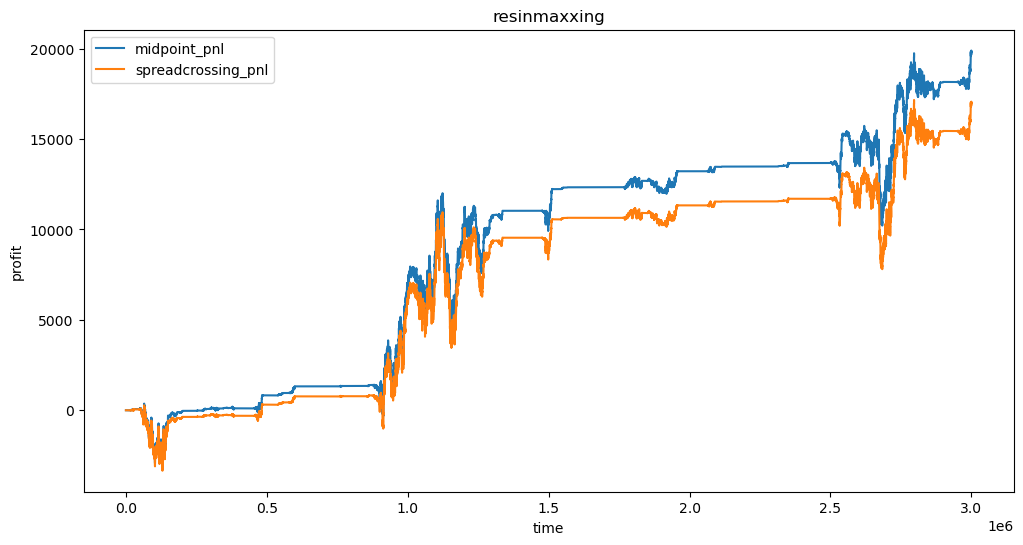

In [51]:
metrics = bt.calculate_metrics("PICNIC_BASKET2")

print(f"Available metrics: {metrics.keys()}")

# metrics['timestamp'] is provided for convenience.
# this should line up with metrics['midpoint_pnl'] and metrics['spreadcrossing_pnl'] (i.e. same shape)

plt.figure(figsize=(12, 6))
plt.plot(metrics["timestamp"], metrics["midpoint_pnl"], label="midpoint_pnl")
plt.plot(metrics["timestamp"], metrics["spreadcrossing_pnl"], label="spreadcrossing_pnl")
print(metrics["midpoint_sharpe"])
print(metrics["spreadcrossing_sharpe"])
plt.title("resinmaxxing")
plt.xlabel("time")
plt.ylabel("profit")
plt.legend()